In [1]:
import pypsa
import numpy as np
import os
import sys
import re
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

sys.path.append(str(Path.cwd() / ".." / "scripts"))

from make_egs_plots import plot_timeseries, plot_geothermal_map

model_name = "elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc"
dir_template = "egs_sweep_{}"

costs_2_evaluate = np.arange(300000, 500000, 10000)

energies, capacities, costs = list(), list(), list() 

for costs in costs_2_evaluate:

    model_path = Path.cwd() / dir_template.format(int(costs)) / "postnetworks" / model_name

    n = pypsa.Network(model_path)

    # capcost = re.sub("[^0-9]", "", ex)
    print("+========================== Capital Cost {} ================================".format(costs))
    print(model_path)

    energy, _, _ = plot_geothermal_map(n, "AC", return_data=True, do_plot=False)

    energies.append(energy)    
    # plot_timeseries(n, "all", "AC")

INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 300000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_300000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 310000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_310000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 320000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_320000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 330000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_330000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 340000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_340000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 350000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_350000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 360000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_360000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 370000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_370000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 380000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_380000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 390000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_390000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 400000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_400000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 410000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_410000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 420000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_420000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 430000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_430000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 440000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_440000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 450000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_450000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 460000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_460000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 470000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_470000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 480000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_480000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 490000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_490000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


In [6]:
import pandas as pd


country_shares = pd.DataFrame(index=energies[0].groupby(level=0).sum().index.tolist() + ["EU"])

for costs, df in zip(costs_2_evaluate, energies):

    idx = pd.IndexSlice
    gt = df.loc[idx[:,"geothermal heat"]]

    totals = df.groupby(level=0).sum()
    totals = pd.concat((totals, pd.Series({"EU": totals.sum()})))
    
    diff = totals.drop(index=["EU"]).index.difference(gt.index)
    gt = pd.concat((
        gt, 
        pd.Series(np.zeros_like(diff), index=diff), 
        pd.Series({"EU": gt.sum()})))

    percentages = gt.divide(totals)

    country_shares[costs] = percentages


country_shares.to_csv("country_shares.csv")
totals.to_csv("total_energies.csv")

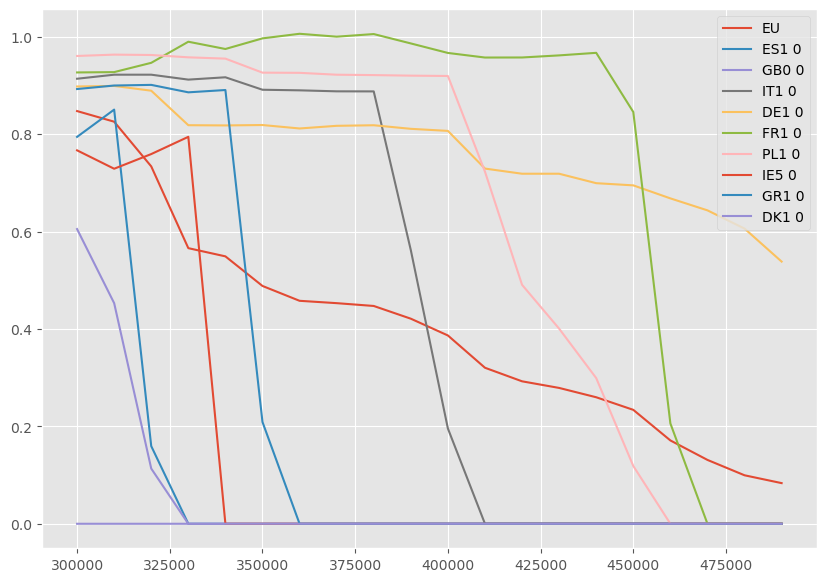

In [10]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

n_show = 10

show_countries = totals.sort_values(ascending=False).iloc[:n_show].index 

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

x = country_shares.columns.values.astype(float)

for country in country_shares.loc[show_countries].index:
    ax.plot(x, country_shares.loc[country].values, label=country) 

ax.legend()

plt.show()

##### Geothermal Map

In [ ]:


regions = gpd.read_file(Path.cwd() / ".." / ".." / "resource_backups" / "resources" / "egs_test" /
    "regions_onshore_elec_s_37.geojson")

regions.index = regions.name
regions = regions.drop(columns="name")
regions.head()

plot_geothermal_map(n, "AC")
plot_geothermal_map(n, "urban central heat")

In [ ]:
import seaborn as sns





get_geothermal_capacity_barchart(hold)

In [6]:
import yaml
from pathlib import Path

Path.cwd()
with open(Path.cwd() / ".." / "config.yaml") as f:
    cfg = yaml.safe_load(f)

cfg["run"]["name"] = "kannichdieconfigaendern"
cfg["sector"]["egs_fixed_capital_cost"] = 4.

with open(Path.cwd() / ".." / "kannichdieconfigaendern.yaml", "w") as f:
    yaml.dump(cfg, f)